In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
#from Preprocessing import clean_text, remove_names, entity_recognizing, remove_url
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import l2
import re
import os

%matplotlib inline
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
path = "drive/MyDrive/IAS/NLP_and_Web/data/twitter.csv"
df_training = pd.read_csv(path)
df_training = df_training.rename(columns={'class': 'label'})
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24472 entries, 0 to 24471
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24472 non-null  int64 
 1   tweet       24472 non-null  object
 2   label       24472 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 573.7+ KB


In [ ]:
df_training.head(5)

,Unnamed: 0,tweet,label
0,0,As a woman you shouldn't complain about cleani...,0
1,1,boy dats cold...tyga dwn bad for cuffin dat ho...,1
2,2,Dawg : You ever fuck a bitch and she start to...,1
3,3,she look like a tranny,1
4,4,The shit you hear about me might be true or it...,1


In [ ]:
df_training.drop(['Unnamed: 0'],axis=1)

,tweet,label
0,As a woman you shouldn't complain about cleani...,0
1,boy dats cold...tyga dwn bad for cuffin dat ho...,1
2,Dawg : You ever fuck a bitch and she start to...,1
3,she look like a tranny,1
4,The shit you hear about me might be true or it...,1
...,...,...
24467,you's a muthaf***in lie : right His TL is tr...,1
24468,"you've gone and broke the wrong heart baby, an...",0
24469,young buck wanna eat.. dat nigguh like I aint ...,1
24470,youu got wild bitches tellin you lies,1


In [ ]:
df_training.duplicated(subset=['tweet']).value_counts()

False    24472
dtype: int64

In [ ]:
df_training['label'].value_counts()


1    18967
0     4099
2     1406
Name: label, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3b8611c90>],
      dtype=object)

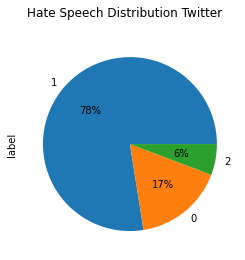

In [ ]:
df_training.label.value_counts().plot(kind='pie', subplots=True,autopct='%1.0f%%', title='Hate Speech Distribution Twitter')

## class = class label for majority of CF users. 0 - normal 1 - offensive language 2 - hate

In [ ]:
def filter_hatespeech_tweets(df):
    
    def filter_tweets(tweet):
        return re.sub('@.\:|!|@\w+:|@[\w]*|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', tweet)

    def postprocess_filter_tweets(tweet):
        
        return df

    df['tweet'] = df['tweet'].apply(filter_tweets)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    
    return df

df_training = filter_hatespeech_tweets(df_training)

In [ ]:
TEXT_COLUMN = "tweet"
LABEL_COLUMN = "label"

print("Converting to lower-case")
df_training[TEXT_COLUMN] = df_training[TEXT_COLUMN].str.lower()
df_training.head()

Converting to lower-case


,Unnamed: 0,tweet,label
0,0,as a woman you shouldn't complain about cleani...,0
1,1,boy dats cold...tyga dwn bad for cuffin dat ho...,1
2,2,dawg : you ever fuck a bitch and she start to...,1
3,3,she look like a tranny,1
4,4,the shit you hear about me might be true or it...,1


In [ ]:
df_training['doc_len'] = df_training[TEXT_COLUMN].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df_training['doc_len'].mean() + df_training['doc_len'].std()).astype(int)

In [ ]:
df_training.head()

,Unnamed: 0,tweet,label,doc_len
0,0,as a woman you shouldn't complain about cleani...,0,22
1,1,boy dats cold...tyga dwn bad for cuffin dat ho...,1,13
2,2,dawg : you ever fuck a bitch and she start to...,1,18
3,3,she look like a tranny,1,5
4,4,the shit you hear about me might be true or it...,1,22


## Splitting the data

In [ ]:
seed = 11
test_size = 0.1
#categories = ['hate speech', 'offensive language', 'neither']
categories = [0,1,2]
def split_dataset(df, seed, test_size):
    #train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    #return train.tweet, train.label, test.tweet, test.label
    return df.tweet, df.label, df.tweet, df.label

In [ ]:
train, train_targets, test, test_targets = split_dataset(df_training, seed=seed, test_size=test_size)

In [ ]:
train_targets.values

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
train_targets.shape

(24472,)

In [ ]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1]], [s.index[2], s[2]]

In [ ]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [ ]:
embed_size = 300  # how big is each word vector
max_features = None  # how many unique words to use (i.e num rows in embedding vector)
maxlen = max_seq_len  # max number of words in a question to use #99.99%

def encode(data, label):
    # fill up the missing values
    X = data.fillna("_na_").values
    total_tweets = df_training.tweet.fillna("_na_").values
    
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(list(total_tweets))
    X = tokenizer.texts_to_sequences(X)
    vocab_size = len(tokenizer.word_index) + 1
    print(tokenizer.word_index)
    
    # Pad the sentences
    X = pad_sequences(X, maxlen=maxlen)
    print(X.shape)
    
    # Get the target values
    y = pd.get_dummies(label.values)
    print(y.shape)
    #le = LabelEncoder()
    #le.fit(Y_train)
    #encoded_Y = le.transform(Y_train)
    return X,y,vocab_size
    

In [ ]:
# FETCH DATA, LABELS, DICTIONARIES
X_train, y_train, vocab_size = encode(train, train_targets)
X_test, y_test, vocab_size = encode(test, test_targets)

print(vocab_size)

{'a': 1, ':': 2, 'i': 3, 'the': 4, 'bitch': 5, 'you': 6, 'to': 7, 'and': 8, 'my': 9, 'that': 10, 'in': 11, 'is': 12, 'bitches': 13, 'like': 14, 'of': 15, 'http:': 16, 'on': 17, 'me': 18, 'be': 19, 'for': 20, 'this': 21, 'hoes': 22, 'with': 23, 'pussy': 24, 'it': 25, 'hoe': 26, "i'm": 27, 'your': 28, 'ass': 29, 'if': 30, 'all': 31, 'just': 32, 'but': 33, "don't": 34, 'get': 35, 'up': 36, 'they': 37, 'so': 38, 'fuck': 39, 'when': 40, 'these': 41, 'got': 42, 'u': 43, 'no': 44, 'was': 45, 'not': 46, 'she': 47, 'are': 48, 'shit': 49, 'at': 50, 'her': 51, 'nigga': 52, 'have': 53, 'out': 54, 'lol': 55, 'about': 56, 'some': 57, 'he': 58, "ain't": 59, 'trash': 60, '&amp;': 61, 'what': 62, 'know': 63, 'can': 64, 'do': 65, 'we': 66, 'niggas': 67, 'how': 68, "it's": 69, 'love': 70, 'or': 71, 'as': 72, 'them': 73, 'one': 74, 'who': 75, 'fucking': 76, '":': 77, 'yo': 78, 'go': 79, 'want': 80, "can't": 81, 'from': 82, 'bitch.': 83, 'his': 84, 'why': 85, 'then': 86, 'bad': 87, "you're": 88, 'good': 89

In [ ]:
y_train

,0,1,2
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
24467,0,1,0
24468,1,0,0
24469,0,1,0
24470,0,1,0


Loading the Movies dataset and preparing the encodings for each utterences

In [ ]:
df_AllMovie = pd.read_csv('/content/drive/MyDrive/IAS/NLP_and_Web/data/all_movies.csv')
df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


In [ ]:

df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


In [ ]:
X_test_AllMovie, y_test_AllMovie, vocab_size = encode(df_AllMovie['text'], df_AllMovie['majority_answer'])
print(vocab_size)

{'a': 1, ':': 2, 'i': 3, 'the': 4, 'bitch': 5, 'you': 6, 'to': 7, 'and': 8, 'my': 9, 'that': 10, 'in': 11, 'is': 12, 'bitches': 13, 'like': 14, 'of': 15, 'http:': 16, 'on': 17, 'me': 18, 'be': 19, 'for': 20, 'this': 21, 'hoes': 22, 'with': 23, 'pussy': 24, 'it': 25, 'hoe': 26, "i'm": 27, 'your': 28, 'ass': 29, 'if': 30, 'all': 31, 'just': 32, 'but': 33, "don't": 34, 'get': 35, 'up': 36, 'they': 37, 'so': 38, 'fuck': 39, 'when': 40, 'these': 41, 'got': 42, 'u': 43, 'no': 44, 'was': 45, 'not': 46, 'she': 47, 'are': 48, 'shit': 49, 'at': 50, 'her': 51, 'nigga': 52, 'have': 53, 'out': 54, 'lol': 55, 'about': 56, 'some': 57, 'he': 58, "ain't": 59, 'trash': 60, '&amp;': 61, 'what': 62, 'know': 63, 'can': 64, 'do': 65, 'we': 66, 'niggas': 67, 'how': 68, "it's": 69, 'love': 70, 'or': 71, 'as': 72, 'them': 73, 'one': 74, 'who': 75, 'fucking': 76, '":': 77, 'yo': 78, 'go': 79, 'want': 80, "can't": 81, 'from': 82, 'bitch.': 83, 'his': 84, 'why': 85, 'then': 86, 'bad': 87, "you're": 88, 'good': 89

## Creating the model

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, embed_size, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 4
batch_size = 32
lr = 0.001


model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_size, input_length=X_train.shape[1]),
        tf.keras.layers.LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        tf.keras.layers.Dense(3, activation = 'softmax')
  ])

model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           9415500   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 9,509,135
Trainable params: 9,509,135
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, 
      epochs=epochs,  
      verbose=1, 
      validation_split=0.10,
      batch_size=batch_size)

Epoch 1/4
689/689 [==============================] - 87s 122ms/step - loss: 1.6768 - accuracy: 0.8050 - precision: 0.8147 - recall: 0.7122 - val_loss: 0.4996 - val_accuracy: 0.8893 - val_precision: 0.9017 - val_recall: 0.8770
Epoch 2/4
689/689 [==============================] - 84s 121ms/step - loss: 0.4073 - accuracy: 0.9112 - precision: 0.9257 - recall: 0.8996 - val_loss: 0.4069 - val_accuracy: 0.8844 - val_precision: 0.8971 - val_recall: 0.8693
Epoch 3/4
689/689 [==============================] - 84s 122ms/step - loss: 0.2643 - accuracy: 0.9325 - precision: 0.9443 - recall: 0.9246 - val_loss: 0.4270 - val_accuracy: 0.8836 - val_precision: 0.8933 - val_recall: 0.8685
Epoch 4/4
689/689 [==============================] - 84s 122ms/step - loss: 0.2104 - accuracy: 0.9513 - precision: 0.9588 - recall: 0.9437 - val_loss: 0.4489 - val_accuracy: 0.8799 - val_precision: 0.8920 - val_recall: 0.8701


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test,batch_size=32)
print("loss: %s accuracy: %s precision: %s recall: %s" % (loss, accuracy, precision, recall))

df_evaluation = pd.DataFrame({'loss':loss, 'accuracy':accuracy, 'precision': precision, 'recall':recall},index=[0])

In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/evaluation_logs_lstm_twitter.csv'
df_evaluation.to_csv(name)
df_evaluation

In [ ]:
Y_pred = model.predict(X_test)
Y_pred.shape

In [ ]:
Y_pred

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)
Y_pred

In [ ]:
categories = ['hate speech', 'offensive language', 'neither']
 
report = classification_report(test_targets.values, Y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_lstm_twitter.csv'
df_report.to_csv(name)

In [ ]:
df_results = pd.DataFrame(history.history)
df_results['num_epochs'] = epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] =  len(categories) 
df_results['test_size'] = test_size
df_results['train_size'] = len(train)
df_results['seed'] = seed
df_results['Tokenizer'] = 'keras_preprocessing.text.Tokenizer'
df_results['loss_function'] = 'categorical_crossentropy'
df_results['learning_rate'] = lr
df_results['train_class_proportion_' + categories[0]] = round(train_class_distribution[0][1], 2)
df_results['train_class_proportion_' + categories[1]] = round(train_class_distribution[1][1], 2)
df_results['train_class_proportion_' + categories[2]] = round(train_class_distribution[2][1], 2)
df_results['test_class_proportion_' + categories[0]] = round(test_class_distribution[0][1], 2)
df_results['test_class_proportion_' + categories[1]] = round(test_class_distribution[1][1], 2)
df_results['test_class_proportion_' + categories[2]] = round(test_class_distribution[2][1], 2)

In [ ]:
df_results.head()

In [ ]:
name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_lstm_twitter.csv'
df_results.to_csv(name)

In [ ]:
def plot_loss(path, ax, title):
    df = pd.read_csv(path)
    df.loss.plot(kind='line', legend=True, title=title, ax=ax, figsize=(15,8))
    ax.legend(loc='upper right')
    plt.xlabel('Step') 
    plt.ylabel('Loss')

In [ ]:
fig, axs = plt.subplots(1,1)
path = '/content/drive/MyDrive/IAS/NLP_and_Web/report/training_logs_lstm_twitter.csv'
plot_loss(path, axs, title='Loss LSTM for Twitter Dataset')

### Test the model on the 6 movies Dataset

In [ ]:
df_AllMovie

,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX
...,...,...,...,...,...,...
10683,10683,TheWolfofWallStreet2013BluRay_3724,3859903933,0,Sell me this pen.,TheWolfofWallStreet
10684,10684,TheWolfofWallStreet2013BluRay_3725,3859903933,0,"Well, it's a nice pen.",TheWolfofWallStreet
10685,10685,TheWolfofWallStreet2013BluRay_3726_3727,3859903933,0,You can use the pen to write down thoughts fro...,TheWolfofWallStreet
10686,10686,TheWolfofWallStreet2013BluRay_3728,3859903933,0,Sell me this pen.,TheWolfofWallStreet


In [ ]:
def annotate_all_movie(movie_df, X_test):
    utterances = X_test
    predictions = []
    batch = []
    

    predictions = model.predict(utterances)
    print(predictions)
    predictions = np.argmax(predictions, axis=1)
    print(predictions[0:10])


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_twitter': pred})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    # del movie_df['Unnamed: 0']
    # del movie_df['Unnamed: 6']
    # del movie_df['Unnamed: 7']
    # del movie_df['index']

    return movie_df

In [ ]:
annotated_all_movie =  annotate_all_movie(df_AllMovie, X_test_AllMovie) 
annotated_all_movie.head(10)

[[0.1497042  0.5676195  0.2826763 ]
 [0.00238926 0.55091447 0.44669628]
 [0.01516068 0.90178406 0.08305525]
 ...
 [0.00107113 0.872208   0.12672086]
 [0.173705   0.6566046  0.16969043]
 [0.27227348 0.5967264  0.13100013]]
[1 1 1 0 1 1 1 1 1 1]


,Unnamed: 0,movie_id,batch_id,majority_answer,text,movie_name,index,label_LSTM_twitter
0,0,AmericanHistoryX(1998)_1,1566624979,0,Derek.,AmerricanHistoryX,0,1
1,1,AmericanHistoryX(1998)_2,1566624979,1,What the fuck are you thinking?,AmerricanHistoryX,1,1
2,2,AmericanHistoryX(1998)_3,1566624979,0,There's a black guy outside breaking into your...,AmerricanHistoryX,2,1
3,3,AmericanHistoryX(1998)_4,1566624979,0,How long has he been there?,AmerricanHistoryX,3,0
4,4,AmericanHistoryX(1998)_5,1566624979,0,I don't know.,AmerricanHistoryX,4,1
5,5,AmericanHistoryX(1998)_6,1566624979,0,What's going on?,AmerricanHistoryX,5,1
6,6,AmericanHistoryX(1998)_7,1566624979,0,"Not right now, honey. How many?",AmerricanHistoryX,6,1
7,7,AmericanHistoryX(1998)_8,1566624979,0,"Danny, how many?",AmerricanHistoryX,7,1
8,8,AmericanHistoryX(1998)_9,1566624979,0,"One, I think.",AmerricanHistoryX,8,1
9,9,AmericanHistoryX(1998)_10,1566624979,0,Is he strapped?,AmerricanHistoryX,9,1


In [ ]:
annotated_all_movie.to_csv('/content/drive/MyDrive/IAS/NLP_and_Web/annotations/annotations_train_Twitter_test_movies.csv')

In [ ]:
annotated_all_movie[(annotated_all_movie['majority_answer']==0)]['label_LSTM_twitter'].value_counts()

1    6916
0    1706
2     392
Name: label_LSTM_twitter, dtype: int64

In [ ]:
categories = ['hate speech', 'offensive language', 'neither']
 
report = classification_report(annotated_all_movie['majority_answer'].values, annotated_all_movie['label_LSTM_twitter'].values, target_names=categories, output_dict=True)
df_report_all_movies = pd.DataFrame(report).transpose()
df_report_all_movies

,precision,recall,f1-score,support
hate speech,0.961127,0.189261,0.316248,9014.000000
offensive language,0.141391,0.848551,0.242393,1380.000000
neither,0.123613,0.265306,0.168649,294.000000
accuracy,0.276478,0.276478,0.276478,0.276478
macro avg,0.408710,0.434373,0.242430,10688.000000
weighted avg,0.832247,0.276478,0.302652,10688.000000


In [ ]:
1name = '/content/drive/MyDrive/IAS/NLP_and_Web/report/matrix_report_lstm_train_twitter_test_movies.csv'
df_report_all_movies.to_csv(name)

## Classication of Movies

### Load Movies

In [ ]:
def read_movie_files(pathes):
    result = []
    for path in pathes: 
        directory = os.fsencode(path)

        for file in os.listdir(directory):
            filename = os.fsdecode(file)

            if filename.endswith(".csv"):
                #print(os.path.join(directory, filename))
                #local_df = read_content(path + '//' + filename)
                movie_df = pd.read_csv(path + '//' + filename)
                tag = path.split('/')[-1]
                count_utterances = movie_df.shape[0]
                result.append({'movie_name': filename[:-9], 'count_utterances': count_utterances, 'tag': tag, 'path': path + '//' + filename})
    result_df = pd.DataFrame(result)
    return result_df

In [ ]:
pathes = ['drive/MyDrive/IAS/Semester3/NLP/movies/racism', 'drive/MyDrive/IAS/Semester3/NLP/movies/hate_speech', 'drive/MyDrive/IAS/Semester3/NLP/movies/friendship']

In [ ]:
movie_metadata_df = read_movie_files(pathes)
movie_metadata_df.head()

In [ ]:
movie_metadata_df.tag.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Movie Tag Distribution')

In [ ]:
path = 'drive/MyDrive/IAS/Semester3/NLP/data/all_movies.csv'
all_movie_data = pd.read_csv(path, index_col=0)

In [ ]:
all_movie_data.head()

In [ ]:
def annotate_single_movie(movie_df):
    utterances = movie_df.dialog.values
    predictions = []
    batch = []
    #doc_len = movie_df.dialog.apply(lambda words: len(words.split(" ")))
    #max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)
    # Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(utterances)


 
    utterances = tokenizer.texts_to_sequences(utterances)
    # Pad the sentences
    utterances = pad_sequences(utterances, maxlen=maxlen)
    #print(utterances.shape)
    vocab_size = len(tokenizer.word_index) + 1
    #print(tokenizer.word_index)
    

    predictions = model.predict(utterances)
    predictions = np.argmax(predictions, axis=1)
    #print(predictions)


    result = []
    
    for i, pred in enumerate(predictions):
        result.append({'index': i, 'label_LSTM_twitter': categories[pred]})
    
    result_df = pd.DataFrame(result)
    movie_df = movie_df.merge(result_df, right_index=True, left_index=True)
    
    del movie_df['Unnamed: 0']
    del movie_df['index']

    return movie_df
    

## Annotate Movies

In [ ]:
movie_df = pd.read_csv(pathes[0]+'/12 Angry Men_conv.csv')

In [ ]:
movie_df.head()

In [ ]:
annotate_single_movie(movie_df)

In [ ]:
def movie_data_cleansing(df):
    df = df.replace(r'<[^\\]>', '', regex=True)
    df = df.replace(r'<\\.*>', '', regex=True)
    return df

In [ ]:
def annotate_movies(movie_metadata_df):
    
    pathes = movie_metadata_df.path.values
    tags = movie_metadata_df.tag.values
    movie_names = movie_metadata_df.movie_name.values
    
    result = []
    for i in range(0, movie_metadata_df.shape[0]):
        path = pathes[i]
        tag = tags[i]
        movie_name = movie_names[i]
        print(i+1, movie_metadata_df.shape[0], path, tag, movie_name)
        movie_df = pd.read_csv(path)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = movie_data_cleansing(movie_df)
        movie_df = annotate_single_movie(movie_df)
        
        labels = movie_df.label_LSTM_twitter.values
                
        for i in range(0, len(labels)):
            result.append({'movie_name': movie_name, 'index': i, 'label': labels[i]})
                    
    result_df = pd.DataFrame(result)     
    return result_df

In [ ]:
movies_annotated_df = annotate_movies(movie_metadata_df)

In [ ]:
movies_annotated_df.to_csv('/content/drive/MyDrive/IAS/NLP_and_Web/annotations/annotations_LSTM_twitter.csv')